In [17]:
import serial
import time
from datetime import datetime
import os
import pandas as pd
from firebase_admin import db
import json
import firebase_admin
from firebase_admin import credentials
import matplotlib.pyplot as plt

### Connect to database

In [3]:
databaseURL = "https://gyroscope-ca247-default-rtdb.asia-southeast1.firebasedatabase.app/"

cred = credentials.Certificate("key.json")
firebase_admin.initialize_app(cred,
                              {'databaseURL':databaseURL})

### Write to database

This code run continuously for 37 minutes and 47 seconds. The phenomena I want to capture with the Gyroscope sensor is an earth quake simulation (similar to that of the last credit task). During the 37 minutes, there are 3 earthquakes, at minute 10, at minute 20 and minute 30. 

A bit of context for the code block below. It reads the data (x,y,z) from the Arduino via serial, then save it into a csv and json file along with the timestamp. 

In [33]:
# Function to get the current time
def timestamp():
    return datetime.now().strftime('%Y%m%d%H%M%S')

# Serial port and saving csv, json file in desire destination
ser = serial.Serial('COM4', 9600)
csv_file = os.path.join(r'C:\Users\tomde\OneDrive\Documents\Deakin\Deakin-Data-Science\T1Y2\SIT225 - Data Capture Technologies\Week 5 - Store data to cloud\5.1P\weekly task\arduino', 'data.csv')

try:
    while True:
        # Check if data is waiting in serial buffer
        if ser.in_waiting > 0:
            data = ser.readline().decode('utf-8').strip() # read data from serial port and decode it
            formatted_data = f"{timestamp()}, {data}"
            
            # Add data to csv file
            with open(csv_file, 'a') as file:
                file.write(formatted_data + '\n')
            
            # Add data to json file
            df = pd.read_csv("data.csv", header=None, names=['Timestamp', 'x', 'y', 'z']) # read csv file
            json_data = df.to_json(orient='index', date_format='iso') # convert dataframe to json
            with open('data.json', 'w') as file2:
                file2.write(json_data)
            
            # write to database
            ref = db.reference("/") # reference to the root of the DB
            with open("data.json", "r") as f:
                file_contents = json.load(f)
            ref.set(file_contents)
            
            # print(f"{formatted_data}")
            
        time.sleep(1)
        
except KeyboardInterrupt:
    print("Forced stop by user.")
    
finally:
    ser.close()
    print("Serial port closed.")

Forced stop by user.
Serial port closed.


### Query the Firebase data

In [8]:
firebase_data = ref.get()
display(firebase_data)
display(type(firebase_data))

[{'Timestamp': 20240811140905, 'x': -0.01, 'y': 0.0, 'z': 1.02},
 {'Timestamp': 20240811140906, 'x': 0.0, 'y': 0.0, 'z': 1.03},
 {'Timestamp': 20240811140907, 'x': 0.0, 'y': 0.0, 'z': 1.03},
 {'Timestamp': 20240811140909, 'x': 0.0, 'y': 0.0, 'z': 1.02},
 {'Timestamp': 20240811140910, 'x': 0.0, 'y': 0.0, 'z': 1.03},
 {'Timestamp': 20240811140911, 'x': -0.01, 'y': 0.0, 'z': 1.03},
 {'Timestamp': 20240811140912, 'x': 0.0, 'y': -0.01, 'z': 1.03},
 {'Timestamp': 20240811140913, 'x': 0.0, 'y': 0.01, 'z': 1.02},
 {'Timestamp': 20240811140914, 'x': 0.0, 'y': 0.01, 'z': 1.03},
 {'Timestamp': 20240811140915, 'x': 0.0, 'y': 0.0, 'z': 1.03},
 {'Timestamp': 20240811140917, 'x': 0.0, 'y': 0.0, 'z': 1.03},
 {'Timestamp': 20240811140918, 'x': 0.0, 'y': 0.0, 'z': 1.03},
 {'Timestamp': 20240811140919, 'x': 0.0, 'y': 0.0, 'z': 1.03},
 {'Timestamp': 20240811140920, 'x': 0.0, 'y': 0.0, 'z': 1.03},
 {'Timestamp': 20240811140921, 'x': 0.0, 'y': 0.0, 'z': 1.03},
 {'Timestamp': 20240811140922, 'x': 0.0, 'y': 0

list

Since I already have a csv file saved when uploading data to the database, I will use it now.

In [14]:
df1 = pd.read_csv("data.csv", header=None, names=['Timestamp', 'x', 'y', 'z'])
display(df1.head())
display(df1.info())

,Timestamp,x,y,z
0,20240811140905,-0.01,0.0,1.02
1,20240811140906,0.00,0.0,1.03
2,20240811140907,-0.00,0.0,1.03
3,20240811140909,-0.00,0.0,1.02
4,20240811140910,-0.00,0.0,1.03


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844 entries, 0 to 1843
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  1844 non-null   int64  
 1   x          1844 non-null   float64
 2   y          1844 non-null   float64
 3   z          1844 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 57.8 KB


None

In [16]:
# Convert `Timestamp` column to time dtype
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y%m%d%H%M%S')
df.head()

,Timestamp,x,y,z
0,2024-08-11 14:09:05,-0.01,0.0,1.02
1,2024-08-11 14:09:06,0.00,0.0,1.03
2,2024-08-11 14:09:07,-0.00,0.0,1.03
3,2024-08-11 14:09:09,-0.00,0.0,1.02
4,2024-08-11 14:09:10,-0.00,0.0,1.03


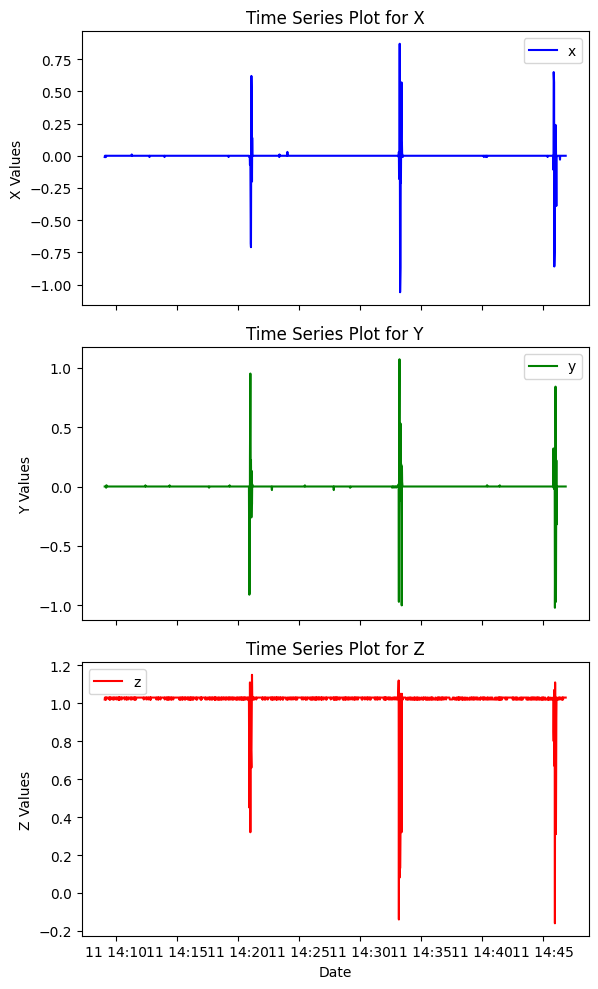

In [20]:
# Subplots
df.set_index('Timestamp', inplace=True)
fig, axs = plt.subplots(3, 1, figsize=(6, 10), sharex=True)

# Plot x
axs[0].plot(df.index, df['x'], label='x', color='b')
axs[0].set_title('Time Series Plot for X')
axs[0].set_ylabel('X Values')
axs[0].legend()

# Plot y
axs[1].plot(df.index, df['y'], label='y', color='g')
axs[1].set_title('Time Series Plot for Y')
axs[1].set_ylabel('Y Values')
axs[1].legend()

# Plot z
axs[2].plot(df.index, df['z'], label='z', color='r')
axs[2].set_title('Time Series Plot for Z')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Z Values')
axs[2].legend()

# Display the plot
plt.tight_layout()
plt.show()

X, Y, Z are rotation on each axis. The rotation of all three axis are mostly static, except at minute 10, 20 and 30, in which I shake the sensor to simulate earthquake. The pattern of earthquake is 10 minute interval, To be specific of the time, we need further analysis. 

In [21]:
df.describe()

,x,y,z
count,1844.000000,1844.000000,1844.000000
mean,-0.001377,-0.000960,1.019555
std,0.062594,0.076862,0.071252
min,-1.060000,-1.020000,-0.160000
25%,-0.000000,0.000000,1.020000
50%,-0.000000,0.000000,1.030000
75%,0.000000,0.000000,1.030000
max,0.870000,1.070000,1.150000


50% percentile is the median value for the 3 rotations. I will filter plus minus 0.2 the median for each rotations.

In [23]:
median = df.describe().loc['50%']
median

x   -0.00
y    0.00
z    1.03
Name: 50%, dtype: float64

In [32]:
df[
    (df['x'] > (median.iloc[0] + 0.2)) | (df['x'] < (median.iloc[0] - 0.2)) | 
    (df['y'] > (median.iloc[1] + 0.2)) | (df['y'] < (median.iloc[1] - 0.2)) | 
    (df['z'] > (median.iloc[2] + 0.2)) | (df['z'] < (median.iloc[2] - 0.2))
]

,x,y,z
Timestamp,,,
2024-08-11 14:20:56,-0.01,-0.91,0.45
2024-08-11 14:20:57,-0.01,-0.90,0.47
2024-08-11 14:20:58,-0.01,-0.82,0.60
2024-08-11 14:20:59,-0.07,0.24,1.11
2024-08-11 14:21:01,0.00,0.95,0.32
2024-08-11 14:21:02,-0.36,0.36,0.82
2024-08-11 14:21:03,-0.68,0.11,0.74
2024-08-11 14:21:04,-0.71,0.22,0.75
2024-08-11 14:21:06,0.62,-0.26,0.66


The first movement is from 14:20:56 to 14:21:07. The second is 14:33:11 to 14:33:25. The last is 14:45:51 to 14:46:06. The interval is not quite exact 10 minutes, but around that.